In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from pandas import concat
from pandas import read_csv
from helper import series_to_supervised, stage_series_to_supervised

2024-05-28 23:23:24.610079: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [11]:
dataset = pd.read_csv('../data/Merged-update_hourly.csv', index_col=0)
dataset.fillna(0, inplace=True)
data = dataset

In [12]:
print(data.columns)

Index(['WS_S1', 'WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A', 'TWS_S25A',
       'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'HWS_S25B', 'TWS_S25B',
       'PUMP_S25B', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2', 'HWS_S26',
       'TWS_S26', 'PUMP_S26', 'MEAN_RAIN'],
      dtype='object')


In [13]:
# specify the number of lag hours
n_hours = 24*7
K = 24

In [14]:
# Pre-processing
# Stage --> 8 stages
stages = dataset[['WS_S1', 'TWS_S25A', 'TWS_S25B', 'TWS_S26']]
print("stages.shape:", stages.shape)


stages_supervised = series_to_supervised(stages, n_hours, K)
print("stages_supervised.shape:", stages_supervised.shape)

stages.shape: (96432, 4)
stages_supervised.shape: (96241, 768)


In [15]:
# stages_head = dataset[['HWS_S25A', 'HWS_S25B', 'HWS_S26']]
# print("stages_head.shape:", stages_head.shape)

# # stages_supervised = stage_series_to_supervised(stages, n_hours, K, 1)
# stages_head_supervised = series_to_supervised(stages_head, n_hours, K)
# print("stages_head_supervised.shape:", stages_head_supervised.shape)

#### Non-stage

In [16]:
# non_stages = data[['WS_S4', 'FLOW_S25A', 'GATE_S25A', 'FLOW_S25B', 'GATE_S25B', 'FLOW_S26', 'GATE_S26', 'PUMP_S26', 'PUMP_S25B', 'MEAN_RAIN']]
non_stages = data[['WS_S4', 'FLOW_S25A', 'FLOW_S25B', 'FLOW_S26', 'PUMP_S26', 'PUMP_S25B', 'MEAN_RAIN']]
print("non_stages.shape:", non_stages.shape)

non_stages_supervised = series_to_supervised(non_stages, n_hours-1, 1)
print("non_stages_supervised.shape:", non_stages_supervised.shape)

non_stages.shape: (96432, 7)
non_stages_supervised.shape: (96265, 1176)


In [17]:
non_stages_supervised_cut = non_stages_supervised.iloc[K:, :]
print("non_stages_supervised_cut.shape:", non_stages_supervised_cut.shape)

non_stages_supervised_cut.shape: (96241, 1176)


In [18]:
# non_stages_supervised_cut

### N_out, N_in, K

In [19]:
# specify the number of lag hours
# n_hours = 72, stages_head.shape[1] +
n_features = stages.shape[1] + non_stages.shape[1]   # 1 rainfall + FGate_S25A + FGate_S25B + FGate_S26 + 8WS + PUMP_S26
# K = 12

In [20]:
n_features

11

### Concatenation

In [21]:
# stages_head_supervised.reset_index(drop=True, inplace=True)
non_stages_supervised_cut.reset_index(drop=True, inplace=True)
stages_supervised.reset_index(drop=True, inplace=True)

all_data = concat([
                   non_stages_supervised_cut.iloc[:, :],
#                    stages_head_supervised.iloc[:, :-3*K],
                   stages_supervised.iloc[:, :]],
                   axis=1)

In [22]:
# print("all_data", all_data)
print("all_data.shape:", all_data.shape)

all_data.shape: (96241, 1944)


### Train & Test set

In [23]:
all_data = all_data.values
n_train_hours = int(len(all_data)*0.8)
print("n_train_hours:", n_train_hours)


train = all_data[:n_train_hours, :]
test = all_data[n_train_hours:, :]

n_train_hours: 76992


### Normalization

In [24]:
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -stages.shape[1]*K:]
test_X, test_y = test[:, :n_obs], test[:, -stages.shape[1]*K:]
print("train_X.shape, train_y.shape, test_X.shape, test_y.shape", train_X.shape, train_y.shape, test_X.shape, test_y.shape)


# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
train_X = scaler.fit_transform(train_X)
train_y = scaler.fit_transform(train_y)
test_X = scaler.fit_transform(test_X)
test_y = scaler.fit_transform(test_y)

train_X.shape, train_y.shape, test_X.shape, test_y.shape (76992, 1848) (76992, 96) (19249, 1848) (19249, 96)


In [25]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print("train_X.shape, train_y.shape, test_X.shape, test_y.shape: \n", train_X.shape, train_y.shape, test_X.shape, test_y.shape)

train_X.shape, train_y.shape, test_X.shape, test_y.shape: 
 (76992, 168, 11) (76992, 96) (19249, 168, 11) (19249, 96)


### Model

- Conv1D(filters=64, kernel_size=12, activation='relu'), SimpleRNN(128), 2000 epoches --> 0.0013

In [19]:
n_outputs = test_y.shape[1]

In [21]:
# define model
model_rcnn_60 = keras.Sequential()
model_rcnn_60.add(layers.SimpleRNN(128, activation="relu", return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model_rcnn_60.add(layers.Conv1D(filters=64, kernel_size=2, activation="relu"))
model_rcnn_60.add(layers.MaxPooling1D(pool_size=2))
# model_rcnn_60.add(layers.SimpleRNN(64, activation="relu"))
model_rcnn_60.add(layers.Flatten())
model_rcnn_60.add(layers.Dense(test_y.shape[1]))

model_rcnn_60.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 168, 128)          17920     
                                                                 
 conv1d_1 (Conv1D)           (None, 167, 64)           16448     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 83, 64)            0         
 g1D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 5312)              0         
                                                                 
 dense_1 (Dense)             (None, 96)                510048    
                                                                 
Total params: 544416 (2.08 MB)
Trainable params: 544416 (2.08 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

Epoch 1/2000

Epoch 00001: val_mae improved from inf to 0.14871, saving model to saved_model/rcnn_24h.h5
151/151 - 12s - loss: 0.0552 - mae: 0.1847 - val_loss: 0.0336 - val_mae: 0.1487
Epoch 2/2000

Epoch 00002: val_mae improved from 0.14871 to 0.12154, saving model to saved_model/rcnn_24h.h5
151/151 - 12s - loss: 0.0143 - mae: 0.0969 - val_loss: 0.0228 - val_mae: 0.1215
Epoch 3/2000

Epoch 00003: val_mae improved from 0.12154 to 0.09915, saving model to saved_model/rcnn_24h.h5
151/151 - 12s - loss: 0.0092 - mae: 0.0764 - val_loss: 0.0155 - val_mae: 0.0991
Epoch 4/2000

Epoch 00004: val_mae improved from 0.09915 to 0.08510, saving model to saved_model/rcnn_24h.h5
151/151 - 12s - loss: 0.0062 - mae: 0.0614 - val_loss: 0.0114 - val_mae: 0.0851
Epoch 5/2000

Epoch 00005: val_mae improved from 0.08510 to 0.07738, saving model to saved_model/rcnn_24h.h5
151/151 - 12s - loss: 0.0047 - mae: 0.0535 - val_loss: 0.0094 - val_mae: 0.0774
Epoch 6/2000

Epoch 00006: val_mae improved from 0.07738 to

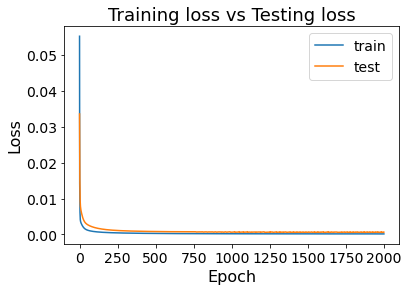

In [24]:
lr = 0.00001
EPOCHS = 2000
model_rcnn_60.compile(
              optimizer=Adam(learning_rate=lr, decay=lr/EPOCHS), 
#               optimizer='adam',
              loss='mse',
              metrics=['mae'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=500)
mc = ModelCheckpoint('../saved_model/rcnn_24h.h5', monitor='val_mae', mode='min', verbose=2, save_best_only=True)


history = model_rcnn_60.fit(train_X, train_y,
                            batch_size=512,
                            epochs=EPOCHS,
                            validation_data=(test_X, test_y),
                            verbose=2,
                            shuffle=False,
                           callbacks=[es, mc])

plt.rcParams["figure.figsize"] = (8, 6)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(fontsize=14)
plt.title("Training loss vs Testing loss", fontsize=18)
# plt.savefig('graph/rnn_loss.png', dpi=300)
plt.show()

In [26]:
from tensorflow.keras.models import load_model

model_load = load_model('../saved_model/rcnn.h5')

### Performance

In [27]:
import time
# start_time = time.time()

yhat = model_load.predict(test_X)

inv_yhat = scaler.inverse_transform(yhat)
inv_y = scaler.inverse_transform(test_y)

inv_yhat = pd.DataFrame(inv_yhat)
inv_y = pd.DataFrame(inv_y)
print("inv_y.shape, inv_yhat.shape", inv_y.shape, inv_yhat.shape)


# elapsed_time = time.time() - start_time
# print('Execution time:', elapsed_time, 'seconds')

2024-05-28 23:24:14.345168: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2024-05-28 23:24:14.346070: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 1700105000 Hz
2024-05-28 23:24:14.552466: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2024-05-28 23:24:14.777536: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


inv_y.shape, inv_yhat.shape (19249, 96) (19249, 96)


In [28]:
# inv_y

In [29]:
# inv_yhat

In [30]:
error_abs = abs(inv_yhat - inv_y)
# error_abs

In [31]:
error = inv_yhat - inv_y
# error

In [32]:
## 17544 = 24 * (365+366)
error_19_20 = error.iloc[-17544:, :]

In [33]:
len(error_19_20)

17544

In [34]:
# inv_y.to_csv('./output/inv_y_rnn_cnn.csv')
# inv_yhat.to_csv('./output/inv_yhat_rnn_cnn.csv')
# error.to_csv('output/error_rnn_cnn.csv')

In [35]:
print('MAE = {}'.format(float("{:.4f}".format(mae(inv_yhat.iloc[:, :], inv_y.iloc[:, :])))))
print('RMSE = {}'.format(float("{:.4f}".format(sqrt(mse(inv_yhat.iloc[:, :], inv_y.iloc[:, :]))))))

MAE = 0.1046
RMSE = 0.1338


In [36]:
S1_index = [i for i in range(0, K*4, 4)]
S25A_index = [i+1 for i in range(0, K*4, 4)]
S25B_index = [i+2 for i in range(0, K*4, 4)]
S26_index = [i+3 for i in range(0, K*4, 4)]
# print(S26_index)

In [37]:
locations = ['WS_S1', 'TWS_S25A', 'TWS_S25B', 'TWS_S26']
loc_index = [S1_index, S25A_index, S25B_index, S26_index]
for i in range(len(locations)):
    print('Errors of {}'.format(locations[i]))
    print('MAE = {}'.format(float("{:.4f}".format(mae(inv_yhat.iloc[:, loc_index[i]], inv_y.iloc[:, loc_index[i]])))))
    print('RMSE = {}'.format(float("{:.4f}".format(sqrt(mse(inv_yhat.iloc[:, loc_index[i]], inv_y.iloc[:, loc_index[i]]))))))
    print('====================')

Errors of WS_S1
MAE = 0.0882
RMSE = 0.1074
Errors of TWS_S25A
MAE = 0.072
RMSE = 0.101
Errors of TWS_S25B
MAE = 0.0831
RMSE = 0.1095
Errors of TWS_S26
MAE = 0.1753
RMSE = 0.1947


In [40]:
from tensorflow.keras.models import load_model
models = ['mlp', 'rnn', 'lstm', 'cnn', 'rcnn_24h']

for i in range(len(models)):
    print("========= {} =========".format(models[i]))
    saved_model = load_model('saved_model/{}.h5'.format(models[i]))
    yhat = saved_model.predict(test_X)
    inv_yhat = scaler.inverse_transform(yhat)
    inv_y = scaler.inverse_transform(test_y)
    inv_yhat = pd.DataFrame(inv_yhat)
    inv_y = pd.DataFrame(inv_y)
    error = inv_y - inv_yhat
    print('1h MAE = {}'.format(float("{:.6f}".format(mae(inv_yhat.iloc[:, 0:4], inv_y.iloc[:, 0:4])))))
    print('1h RMSE = {}'.format(float("{:.6f}".format(sqrt(mse(inv_yhat.iloc[:, 0:4], inv_y.iloc[:, 0:4]))))))
    print('8h MAE = {}'.format(float("{:.6f}".format(mae(inv_yhat.iloc[:, 28:32], inv_y.iloc[:, 28:32])))))
    print('8h RMSE = {}'.format(float("{:.6f}".format(sqrt(mse(inv_yhat.iloc[:, 28:32], inv_y.iloc[:, 28:32]))))))
    print('16h MAE = {}'.format(float("{:.6f}".format(mae(inv_yhat.iloc[:, 60:64], inv_y.iloc[:, 60:64])))))
    print('16h RMSE = {}'.format(float("{:.6f}".format(sqrt(mse(inv_yhat.iloc[:, 60:64], inv_y.iloc[:, 60:64]))))))
    print('24h MAE = {}'.format(float("{:.6f}".format(mae(inv_yhat.iloc[:, 92:96], inv_y.iloc[:, 92:96])))))
    print('24h RMSE = {}'.format(float("{:.6f}".format(sqrt(mse(inv_yhat.iloc[:, 92:96], inv_y.iloc[:, 92:96]))))))
    print('All MAE = {}'.format(float("{:.6f}".format(mae(inv_yhat.iloc[:, :], inv_y.iloc[:, :])))))
    print('All RMSE = {}'.format(float("{:.6f}".format(sqrt(mse(inv_yhat.iloc[:, :], inv_y.iloc[:, :]))))))

========= mlp =========
1h MAE = 0.154329
1h RMSE = 0.192667
8h MAE = 0.148733
8h RMSE = 0.192816
16h MAE = 0.146393
16h RMSE = 0.181548
24h MAE = 0.173591
24h RMSE = 0.21322
All MAE = 0.156618
All RMSE = 0.197095
========= rnn =========
1h MAE = 0.078707
1h RMSE = 0.101829
8h MAE = 0.10951
8h RMSE = 0.143407
16h MAE = 0.128287
16h RMSE = 0.16979
24h MAE = 0.128722
24h RMSE = 0.170077
All MAE = 0.114897
All RMSE = 0.152183
========= lstm =========
1h MAE = 0.166499
1h RMSE = 0.20891
8h MAE = 0.279821
8h RMSE = 0.356644
16h MAE = 0.243322
16h RMSE = 0.302895
24h MAE = 0.18431
24h RMSE = 0.235124
All MAE = 0.239587
All RMSE = 0.3032
========= cnn =========
1h MAE = 0.08485
1h RMSE = 0.109176
8h MAE = 0.091022
8h RMSE = 0.115818
16h MAE = 0.105238
16h RMSE = 0.139705
24h MAE = 0.114896
24h RMSE = 0.145716
All MAE = 0.103432
All RMSE = 0.133906
========= rcnn_24h =========
1h MAE = 0.090893
1h RMSE = 0.118606
8h MAE = 0.095009
8h RMSE = 0.122238
16h MAE = 0.094039
16h RMSE = 0.122412
24h M